# **DEPENDENCE**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

import librosa
import soundfile
import pyaudio
import wave

import random
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import (roc_curve, roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, classification_report, confusion_matrix)

import xgboost as xgb
from xgboost import XGBClassifier, plot_tree


import multiprocessing
import threading

import time
import warnings
warnings.filterwarnings("ignore")

------
------
------

# **DATA PREPARE**

In [7]:
def extract_feature(wav_path):
    signal, sr = librosa.load(wav_path, sr=None)
    signal = signal[int(0.3*sr):int(0.5*sr)]
    
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(signal)

    features = np.concatenate([mfcc.flatten(), 
                              spectral_contrast.flatten(), 
                              spectral_centroid.flatten(), 
                              zero_crossing_rate.flatten()])
    return features

In [8]:
def feature_prepare(DATA):
    wav_data = []
    wav_labels = []
    for root, _, wav_list in os.walk(DATA):
        if len(wav_list) != 0:
            random.shuffle(wav_list)
            random.shuffle(wav_list)

        for wav_name in tqdm(wav_list):
            if wav_name.endswith('.wav'):
                wav_path = os.path.join(root, wav_name)
                features = extract_feature(wav_path)
                wav_data.append(features)
                wav_labels.append(0 if "NG" in wav_name else 1)
    features_arr, targets = np.array(wav_data), np.array(wav_labels)
    encoder = LabelEncoder()
    targets_onehot = encoder.fit_transform(targets)
    return features_arr, targets_onehot

In [9]:
features_train, targets_train = feature_prepare("DATA_12-1-2023/DATASET/TRAIN")
features_test, targets_test = feature_prepare("DATA_12-1-2023/DATASET/TEST")

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:02<00:00, 83.48it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:02<00:00, 84.03it/s]


------
------
------

# **TRAINING PROCESS**

In [10]:
result = {}
for step in tqdm(range(10)):
    X_train, X_test, y_train, y_test = train_test_split(features_train, targets_train, test_size=0.3, shuffle=True)
    
    # Initialize the model
    model = XGBClassifier(n_estimators=1000, 
                          learning_rate=0.05, 
                          eval_metric='mlogloss',
                          verbose=1)
    
    # Train the model
    model.fit(X_train, y_train)

    # Predict mini - test from Train
    y_pred = model.predict(X_test)
    precision_mini = precision_score(y_test, y_pred)
    recall_mini = recall_score(y_test, y_pred)
    f1_mini = f1_score(y_test, y_pred)
    acc_mini = accuracy_score(y_test, y_pred)
    
    # Predict unseen - test
    y_pred = model.predict(features_test)
    precision_unseen = precision_score(targets_test, y_pred)
    recall_unseen = recall_score(targets_test, y_pred)
    f1_unseen = f1_score(targets_test, y_pred)
    acc_unsseen = accuracy_score(targets_test, y_pred)
    
    result[step] = {'model': model, 
                    'accuracy_mini': acc_mini, 
                    'accuracy_unseen': acc_unsseen,
                    'precision_mini': precision_mini, 
                    'recall_mini': recall_mini, 
                    'f1_mini': f1_mini,
                    'precision_unseen': precision_unseen, 
                    'recall_unseen': recall_unseen, 
                    'f1_unseen': f1_unseen}
    
print("Random Split Training Done!!!")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]

Random Split Training Done!!!


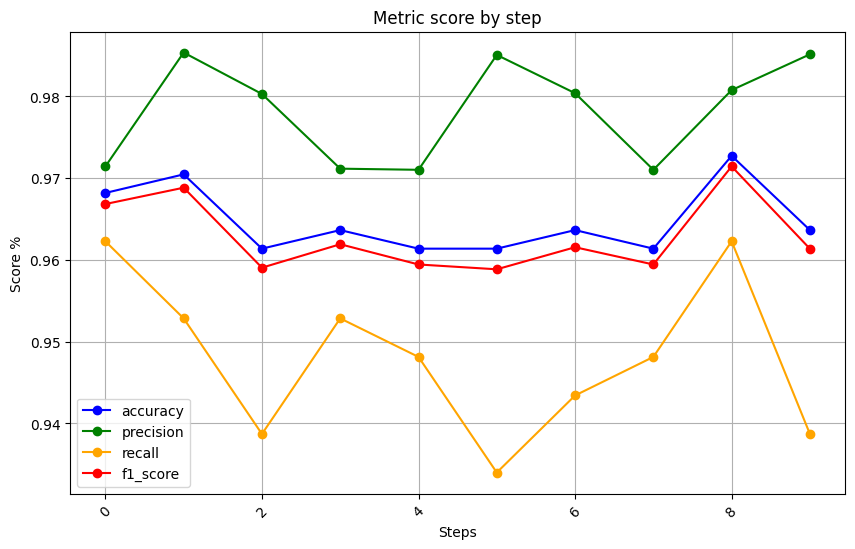

In [11]:
# Tạo danh sách các bước
steps = list(result.keys())

# # Tạo danh sách các giá trị accuracy
accuracy = [result[step]['accuracy_unseen'] for step in steps]

# Tạo danh sách các giá trị precision
precision = [result[step]['precision_unseen'] for step in steps]

# Tạo danh sách các giá trị recall
recall = [result[step]['recall_unseen'] for step in steps]

# Tạo danh sách các giá trị F1-score
f1_score = [result[step]['f1_unseen'] for step in steps]

# Trực quan hóa accuracy
plt.figure(figsize=(10, 6))
plt.title('Metric score by step')
plt.ylabel('Score %')
plt.xlabel('Steps')
plt.xticks(rotation=45)
plt.grid(True)


plt.plot(steps, accuracy, marker='o', color='blue', label='accuracy')
plt.plot(steps, precision, marker='o', color='green', label='precision')
plt.plot(steps, recall, marker='o', color='orange', label='recall')
plt.plot(steps, f1_score, marker='o', color='red', label='f1_score')
plt.legend()
plt.show()

In [18]:
best_model = result[8]['model']

<Axes: >

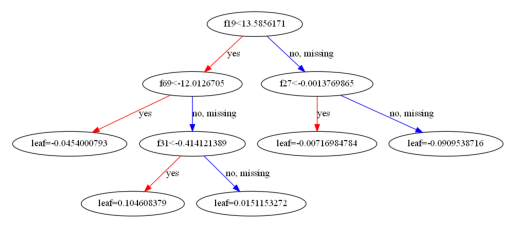

In [19]:
plot_tree(best_model)

------
------
------

# **MODEL EVAL**

In [20]:
scores = cross_val_score(best_model, X_train, y_train, cv=5)
for idx, scr in enumerate(scores):
    print(f"\nAccuracy Fold {idx}: {scr:.2f}")
    
print(f"\nAverage Accuracy: {np.mean(scores):.2f}")


Accuracy Fold 0: 0.98

Accuracy Fold 1: 0.97

Accuracy Fold 2: 0.97

Accuracy Fold 3: 0.90

Accuracy Fold 4: 0.98

Average Accuracy: 0.96


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        72

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133



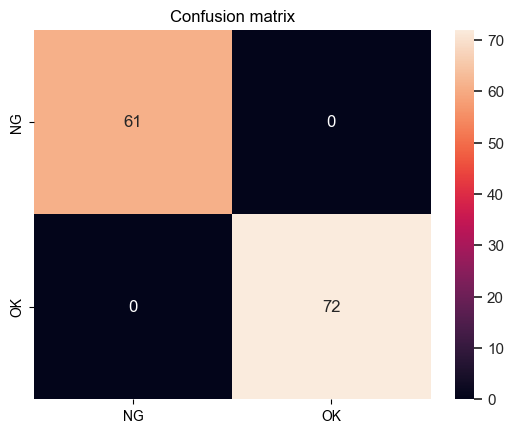

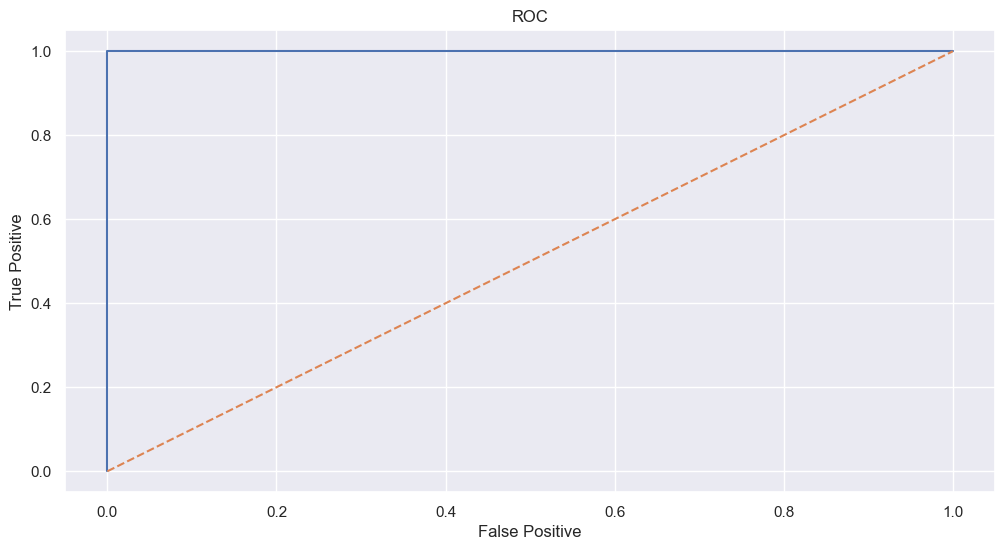

In [21]:
class_dic = {0: 'NG', 1: 'OK'}

y_pred = best_model.predict(X_test)
cf_matrix3 = confusion_matrix(y_test, y_pred)
plt.title("Confusion matrix")
sns.set(rc={'figure.figsize': (12, 6)})
sns.heatmap(cf_matrix3, annot=True, fmt="d", 
            xticklabels=class_dic.values(), yticklabels=class_dic.values())
print(classification_report(y_test, y_pred))
plt.show()

y_pred_prob = best_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       228
           1       0.98      0.96      0.97       212

    accuracy                           0.97       440
   macro avg       0.97      0.97      0.97       440
weighted avg       0.97      0.97      0.97       440



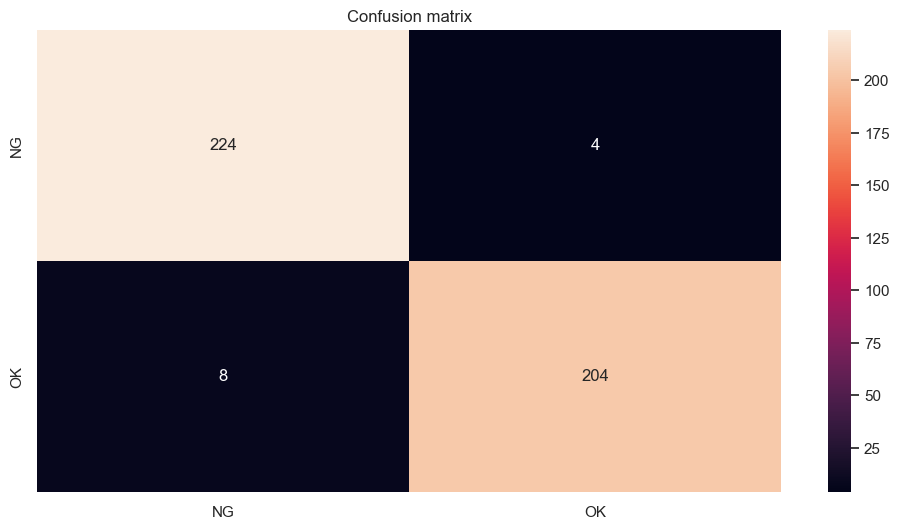

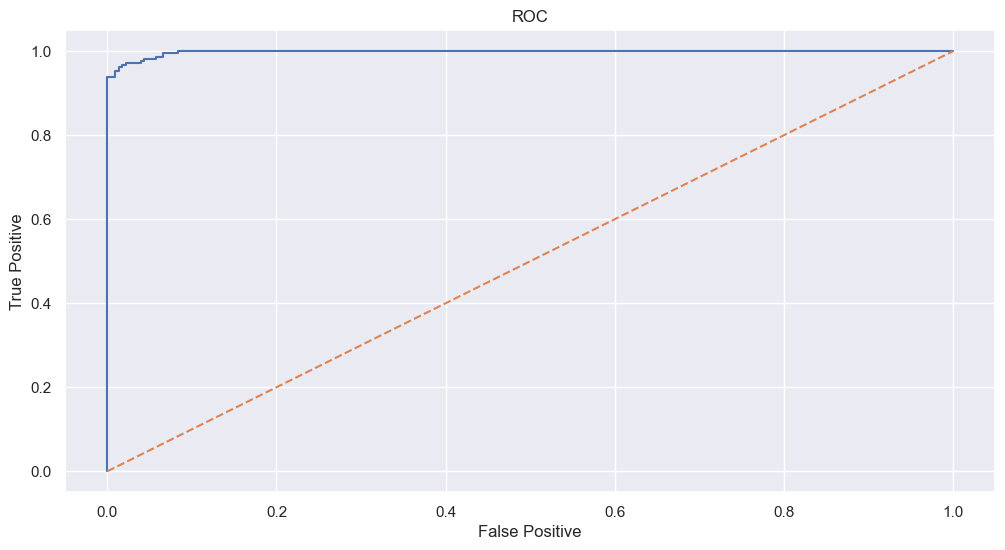

In [22]:
class_dic = {0: 'NG', 1: 'OK'}

y_pred = best_model.predict(features_test)
cf_matrix3 = confusion_matrix(targets_test, y_pred)
plt.title("Confusion matrix")
sns.set(rc={'figure.figsize': (12, 6)})
sns.heatmap(cf_matrix3, annot=True, fmt="d", 
            xticklabels=class_dic.values(), yticklabels=class_dic.values())
print(classification_report(targets_test, y_pred))
plt.show()

y_pred_prob = best_model.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(targets_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.show()

------
------
------
------
------
------

# **SAVE & LOAD & RE-TEST LOADED XGBOOST**

In [23]:
best_model.save_model("XGBoostModelv2.txt")
model_xgb = xgb.XGBClassifier()
model_xgb.load_model("XGBoostModelv2.txt")

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       228
           1       0.98      0.96      0.97       212

    accuracy                           0.97       440
   macro avg       0.97      0.97      0.97       440
weighted avg       0.97      0.97      0.97       440



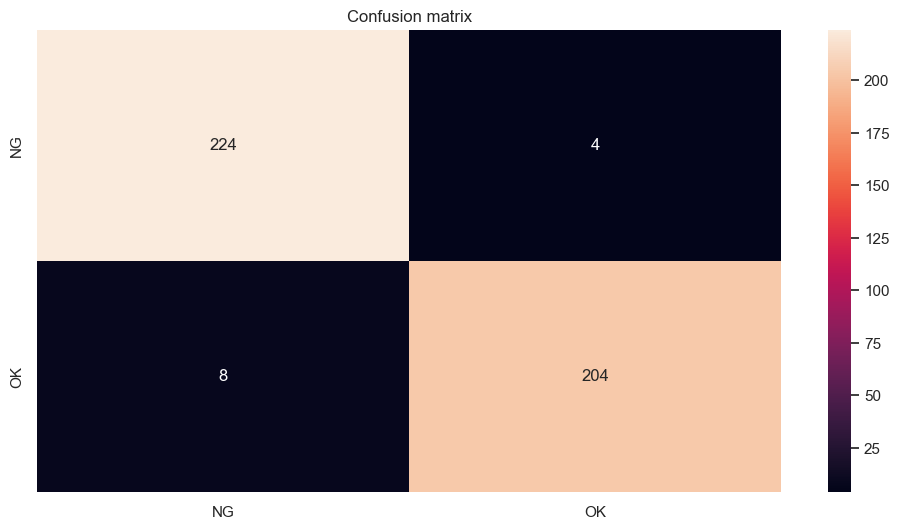

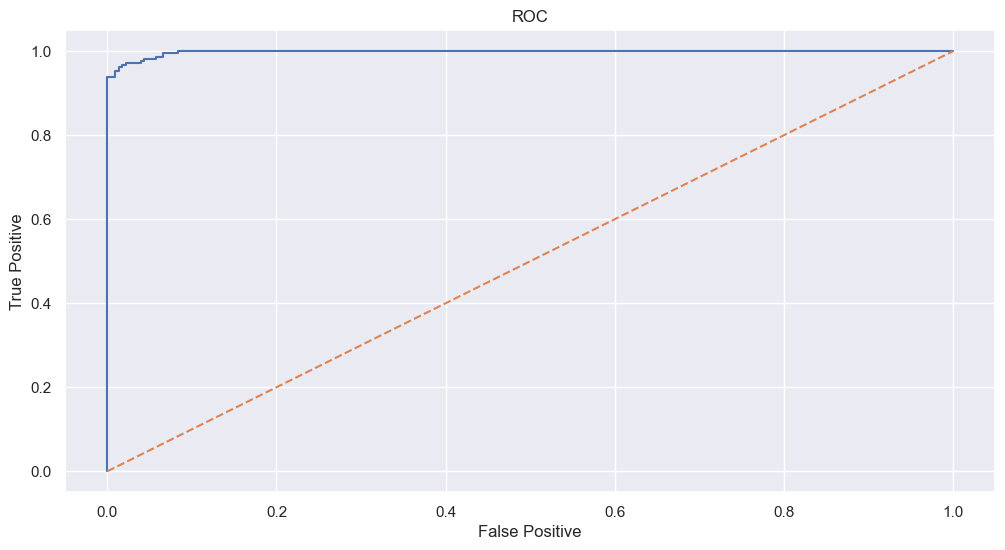

In [24]:
class_dic = {0: 'NG', 1: 'OK'}

y_pred = model_xgb.predict(features_test)
cf_matrix3 = confusion_matrix(targets_test, y_pred)
plt.title("Confusion matrix")
sns.set(rc={'figure.figsize': (12, 6)})
sns.heatmap(cf_matrix3, annot=True, fmt="d", xticklabels=class_dic.values(), yticklabels=class_dic.values())
print(classification_report(targets_test, y_pred))
plt.show()

y_pred_prob = model_xgb.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(targets_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.show()

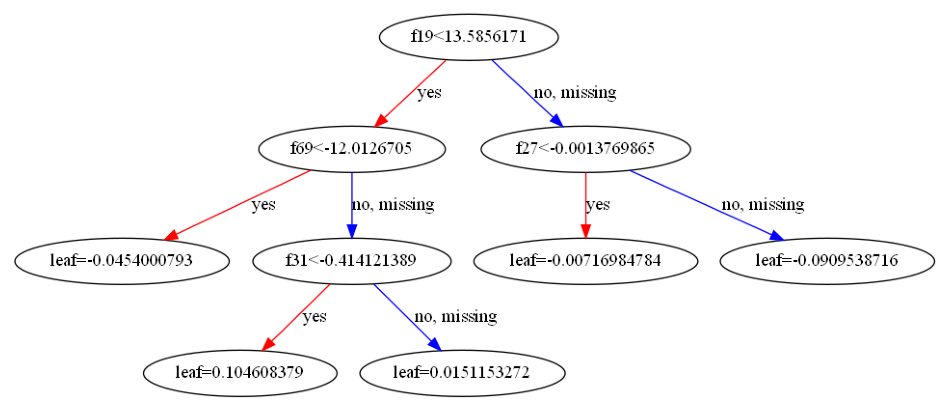

In [25]:
plot_tree(model_xgb)
plt.show()

------
------
------
------

# **INFERENCE FUNCTION**

In [26]:
print("Shape of X_test:", X_test.shape)
print("Shape of first element of X_test:", X_test[0].shape)

Shape of X_test: (133, 882)
Shape of first element of X_test: (882,)


In [27]:
# Test code
class_dic = {0:"NG", 1:"OK"}
element_index = 0
prediction = model_xgb.predict(np.reshape(X_test[0], newshape=(1, -1)))[0]
print(f"Predicted: {class_dic[prediction]} ------------\
       Ground-truth: {class_dic[y_test[element_index]]} ------------\
       {prediction==y_test[element_index]} ------------")


Predicted: OK ------------       Ground-truth: OK ------------       True ------------


In [28]:
def _getPrediction(model, signals, sr=44100, class_dic = {0:"NG", 1:"OK"}):
    signals = signals[int(0.3*sr):int(0.5*sr)]
    mfcc = librosa.feature.mfcc(y=signals, sr=sr, n_mfcc=40)
    spectral_contrast = librosa.feature.spectral_contrast(y=signals, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=signals, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(signals)

    features = np.concatenate([mfcc.flatten(), 
                              spectral_contrast.flatten(), 
                              spectral_centroid.flatten(), 
                              zero_crossing_rate.flatten()])
    features_reshape = np.reshape(features, newshape=(1, -1))
    class_id = model.predict(features_reshape)[0]
    class_label = class_dic[class_id]
    return class_label

In [29]:
signals, sr = librosa.load("DATA_12-1-2023/DATASET/TEST/NG/NG_TEST_FULL_1.wav", sr=None)
class_label = _getPrediction(best_model, signals, sr)
print("Result: ", class_label)

Result:  NG


In [30]:
signals, sr = librosa.load("DATA_12-1-2023/DATASET/TEST/OK/TEST_OK_101.wav", sr=None)
class_label = _getPrediction(best_model, signals, sr)
print("Result: ", class_label)

Result:  OK


In [31]:
# Execution time
s = time.time()
signals, sr = librosa.load("DATA_12-1-2023/DATASET/TEST/OK/TEST_OK_111.wav", sr=None)
class_label = _getPrediction(model_xgb, signals, sr)
print("Result:", class_label)
print(f"Execution time: {(time.time()-s)*1000:.2f} ms")

Result: OK
Execution time: 8.03 ms


In [32]:
ok_path = "DATA_12-1-2023/DATASET/TEST/OK"
ng_path = "DATA_12-1-2023/DATASET/TEST/NG"

file_list = os.listdir(ok_path) + os.listdir(ng_path)
num_files = 400
random_file = random.sample(file_list, num_files)
wrong = 0
times = []
for file_name in random_file:
    if file_name.endswith(".wav"):
        s = time.time()
        gr_truth = 'OK' if 'OK' in file_name else 'NG'
        file_path = os.path.join("DATA_12-1-2023/DATASET/TEST", gr_truth, file_name)
        signals, sr = librosa.load(file_path, sr=None)
        class_label = _getPrediction(best_model, signals, sr)
        time_execution = (time.time()-s)
        boolean = class_label==gr_truth
        
        if (gr_truth,class_label) == ("OK", "NG"):
            state = "Loại Nhầm" 
        elif (gr_truth,class_label) == ("NG", "OK"):
            state = "Lưu xuất" 
        else:

            state = "------------"
        print(f"Truth: {gr_truth:3} | Predicted: {class_label:3} | Bool: {boolean:4}| State: {state:11} | Time: {time_execution*1000:.2f}")
        times.append(time_execution)
        if not boolean:
            wrong +=1
print(f"Averange time execution: {np.mean(times)*1000:.2f} ms")
print(f"Percetage wrong: {(wrong/num_files)*100}% by {num_files} files")

Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 7.58
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 11.02
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 8.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 8.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 8.51
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 7.51
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 8.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 7.51
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 8.56
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 6.51
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 9.06
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 8.02
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 7.01
Truth: NG  | Predicted: 

Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 11.67
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.53
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.03
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 9.52
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.54
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 9.01
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 8.72
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 8.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 8.03
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 8.35
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 8.01
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 7.01
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 8.02
Truth: NG  | Predicte

Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 11.52
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 10.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.05
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 9.06
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 11.03
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 9.03
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.03
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.02
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 10.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 9.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 11.03
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 9.02
Truth: NG  | Pre

Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 10.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 11.01
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 9.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.02
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 9.04
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 11.01
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 10.02
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 49.19
Truth: NG  | Predicted: NG  | Bool:    1| State: ------------ | Time: 10.02
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 12.02
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 9.55
Truth: OK  | Predicted: OK  | Bool:    1| State: ------------ | Time: 9.01
Truth: OK  | Pre

------
------
------
------

# **REAL TIME PREDICTION**

In [169]:
class AudioStream():
    def __init__(self, weight_path:dir=r"XGBoostModel.txt"):
        super().__init__()
        
        """Init parameter for Record"""
        self.sample_rate = 44100
        self.frame_per_buffer = 1058
        self.db_thresh = -25
        self.time_duaration = 0.6

        self.n_mfcc = 20
        self.class_dic = {0:"NG", 1:"OK"}

        self.audio = pyaudio.PyAudio()
        self.stream = self.audio.open(format=pyaudio.paFloat32,
                                      channels=1, rate=self.sample_rate, input=True,
                                      frames_per_buffer=self.frame_per_buffer)
        
        """
        sr:44100 * duration:0.6 = 26460
        frame:1024 --> nframe for 0.6 duration = 26460/1058 ~ 25.8
        """
        
        self.nframe = int((self.sample_rate*self.time_duaration)/self.frame_per_buffer) + 1
        

        self.frames = []
        self.class_label = None
        self.execution_time = None
        self.start_record = None
        self.start_signal = 1
         
        if weight_path is not None:
            self.model = xgb.XGBClassifier()
            self.model.load_model("XGBoostModel.txt")
        else:
            raise "Please input the Model's Weight"

    def _getPrediction(self):
        s = time.time()
        mfcc = librosa.feature.mfcc(y=self.signals, sr=self.sample_rate, n_mfcc=20)
        spectral_contrast = librosa.feature.spectral_contrast(y=self.signals, sr=self.sample_rate)
        spectral_centroid = librosa.feature.spectral_centroid(y=self.signals, sr=self.sample_rate)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(self.signals)

        features = np.concatenate([mfcc.flatten(), 
                                  spectral_contrast.flatten(), 
                                  spectral_centroid.flatten(), 
                                  zero_crossing_rate.flatten()])
        
        features_reshape = np.reshape(features, newshape=(1, -1))
        class_id = self.model.predict(features_reshape)[0]
        self.class_label = self.class_dic[class_id]
        self.execution_time = (time.time()-s)*1000
    
    def process_stream(self):
        # Streaming...
        data = self.stream.read(self.frame_per_buffer)
        databuffer = np.frombuffer(data, dtype=np.float32)
        
        # Calculate max db
        rms = librosa.feature.rms(y=databuffer)
        db = np.max(librosa.amplitude_to_db(rms)[0])
        
        if db and self.start_signal == 1:
            print("Start recording...")
            self.start_signal = 0
        
        if db >= self.db_thresh:
            if self.start_record is None: self.start_record = time.time()
            self.frames.append(databuffer)
        else:
            self.start_record = None
            self.frames = []

    def run(self):
        try:
            print("Initializing...")
            while True:
                self.process_stream()
                if len(self.frames) == self.nframe:
                    print("\n---------------------------------------------------")
                    self.signals = np.concatenate(self.frames)[:int(self.sample_rate*self.time_duaration)]
                    thread_1 = threading.Thread(target=self._getPrediction, args=())
                    thread_1.start()
                    thread_1.join()
                    print(f"Result: {self.class_label} | Inference: {self.execution_time:.2f}ms | Full time: {(time.time()-self.start_record):.2f}s")
                    print("---------------------------------------------------")
                    
                    # self.samples_update.emit(np.concatenate(self.record_full))
                    self.start_record = None
                    self.frames = []
        except KeyboardInterrupt:
            print("Stop recording !!!")

In [170]:
AudioStream().run()

Initializing...
Start recording...

---------------------------------------------------
Result: OK | Inference: 25.23ms | Full time: 0.63s
---------------------------------------------------

---------------------------------------------------
Result: OK | Inference: 18.95ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: OK | Inference: 19.95ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: OK | Inference: 21.09ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: OK | Inference: 22.94ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: OK | Inference: 22.99ms | Full time: 0.62s
---------------------------------------------------

----------------------------


---------------------------------------------------
Result: NG | Inference: 19.92ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 19.92ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 26.70ms | Full time: 0.63s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 20.88ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 18.92ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: OK | Inference: 18.92ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG 


---------------------------------------------------
Result: NG | Inference: 28.93ms | Full time: 0.63s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 37.85ms | Full time: 0.64s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 18.92ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 21.94ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 21.93ms | Full time: 0.63s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 22.91ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG 


---------------------------------------------------
Result: NG | Inference: 22.88ms | Full time: 0.63s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 19.95ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 22.94ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: OK | Inference: 21.95ms | Full time: 0.63s
---------------------------------------------------

---------------------------------------------------
Result: OK | Inference: 22.94ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG | Inference: 18.95ms | Full time: 0.62s
---------------------------------------------------

---------------------------------------------------
Result: NG 